# ML for Earth Observation-LAB3

In [27]:
# Importing essential packages-Utils
import ee
import geemap
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [3]:
# Authenticating and Initializing the Earth Engine API
ee.Authenticate()

ee.Initialize(project='eeproject-412407')

In [4]:
# Creating map object using Geemap
Map = geemap.Map()

##Image Filtering

- Image filtering changes the range (i.e. the pixel values) of an image, so the colors of the image are altered without changing the pixel positions.

- Focus: Gaussian, Laplacian, uniform and median filters

- Dataset: https://developers.google.com/earth-engine/datasets/catalog/USDA_NAIP_DOQQ

In [28]:
# Define the point location-ROI
point = ee.Geometry.Point([-120.42429737386368, 38.3776557020836])

# Load the National Agriculture Imagery Program (NAIP) image collection
naip = ee.ImageCollection("USDA/NAIP/DOQQ")

In [29]:
# Filter the collection by the specified point and select the most recent image
image = naip.filterBounds(point)\
              .sort('system:time_start', False)\
              .first()

# Print the image information
print('Inspect the image object:', image.getInfo())

Inspect the image object: {'type': 'Image', 'bands': [{'id': 'R', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [10090, 12480], 'crs': 'EPSG:26910', 'crs_transform': [0.6, 0, 723456, 0, -0.6, 4257822]}, {'id': 'G', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [10090, 12480], 'crs': 'EPSG:26910', 'crs_transform': [0.6, 0, 723456, 0, -0.6, 4257822]}, {'id': 'B', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [10090, 12480], 'crs': 'EPSG:26910', 'crs_transform': [0.6, 0, 723456, 0, -0.6, 4257822]}, {'id': 'N', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [10090, 12480], 'crs': 'EPSG:26910', 'crs_transform': [0.6, 0, 723456, 0, -0.6, 4257822]}], 'version': 1687352176197076, 'id': 'USDA/NAIP/DOQQ/m_3812037_se_10_060_20220723', 'properties': {'system:time_start': 1658534400000, 'year': 2022, 'system:footprint'

In [30]:
# Display the image with the default visualization
Map.centerObject(point, 18)
Map.addLayer(image, {}, 'Original image')
Map

Map(bottom=3224804.0, center=[38.3776557020836, -120.42429737386368], controls=(WidgetControl(options=['positi…

## Filters (Kernels)

#### Uniform filter
A simple smoothing filter is a square kernel with uniform weights that sum to one.  Convolving with this kernel sets each pixel to the mean of its neighborhood. This kernel is defined by how many pixels it covers (i.e. radius is in units of 'pixels' by default).  A kernel with radius defined in 'meters' adjusts its size in pixels, so you can't visualize its weights, but it's more flexible in terms of adapting to inputs of different scale.

In [31]:

# Define a square, uniform kernel
uniformKernel = ee.Kernel.square(radius=2, units='meters')

# Filter the image by convolving with the smoothing filter
smoothed = image.convolve(uniformKernel)
Map.addLayer(smoothed, {'min': 0, 'max': 255}, 'Smoothed image')
Map

Map(bottom=6449432.0, center=[38.376451859092185, -120.42269825935365], controls=(WidgetControl(options=['posi…

#### Gaussian kernel
A Gaussian kernel can also be used for smoothing.  Think of filtering with a Gaussian kernel as computing the weighted average in each pixel's neighborhood.

In [32]:
# Define a square Gaussian kernel
gaussianKernel = ee.Kernel.gaussian(radius=2, units='meters')

# Filter the image by convolving with the Gaussian filter
gaussian = image.convolve(gaussianKernel)
Map.addLayer(gaussian, {'min': 0, 'max': 255}, 'Gaussian smoothed image')
Map

Map(bottom=25796714.0, center=[38.37693127634413, -120.42471528053285], controls=(WidgetControl(options=['posi…

#### Laplacian kernel
Laplacian kernel is classic edge detection kernel. Convolving with an edge-detection kernel is used to find rapid changes in image that usually signify edges of objects represented in the image data.
Learn more about additional edge detection methods in Earth Engine [here](https://developers.google.com/earth-engine/guides/image_edges)

In [34]:
# Define a Laplacian filter
laplacianKernel = ee.Kernel.laplacian8()

# Filter the image by convolving with the Laplacian filter
edges = image.convolve(laplacianKernel)#.reproject('EPSG:26910', None, 1)
Map.addLayer(edges, {'min': 0, 'max': 255}, 'Laplacian filtered image')
Map

Map(bottom=25796714.0, center=[38.37693127634413, -120.42471528053285], controls=(WidgetControl(options=['posi…

#### Median filter
 A median filter can be useful for denoising images.  Specifically, suppose that random pixels in your image are saturated by anomalously high or low values that result from some noise process.  Filtering the image with a mean filter (as in section 3.a.i) would result in pixel values getting polluted by noisy data.  To avoid that, you can smooth the image with a median filter.

In [35]:
# Apply a median filter to the image
median = image.reduceNeighborhood(reducer=ee.Reducer.median(), kernel=uniformKernel)
Map.addLayer(median, {'min': 0, 'max': 255}, 'Median')
Map

Map(bottom=12898595.0, center=[38.37619532750352, -120.42307376861574], controls=(WidgetControl(options=['posi…

## OpenCV

- Image processing aims to enhance an existing image.

- This helps in training the system (model) to recognise changes in patterns (data augmentation) [here](https://www.picsellia.com/post/image-data-augmentation)

In [36]:
# Data downloading
!wget -O image_lab3.zip "https://drive.google.com/uc?id=112wFxluOATOKpKJ-r3CqrsMBv8eRVJzR"

--2024-02-22 06:31:04--  https://drive.google.com/uc?id=112wFxluOATOKpKJ-r3CqrsMBv8eRVJzR
Resolving drive.google.com (drive.google.com)... 172.217.0.78, 2607:f8b0:4025:810::200e
Connecting to drive.google.com (drive.google.com)|172.217.0.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=112wFxluOATOKpKJ-r3CqrsMBv8eRVJzR [following]
--2024-02-22 06:31:04--  https://drive.usercontent.google.com/download?id=112wFxluOATOKpKJ-r3CqrsMBv8eRVJzR
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.0.65, 2607:f8b0:4025:810::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55739 (54K) [application/octet-stream]
Saving to: ‘image_lab3.zip’

image_lab3.zip      100%[===================>]  54.43K  --.-KB/s    in 0.006s  

2024-02-22 06:31:05 (8.31 MB/s) - ‘image_lab3.zip’ 

In [37]:
!unzip /content/image_lab3.zip # Unzip

Archive:  /content/image_lab3.zip
replace img_dog.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: img_dog.jpg             


In [38]:
# Reading image to get corresponding array format
img_ = cv2.imread("/content/img_dog.jpg")
img_.shape # Checking image shape

(224, 224, 3)

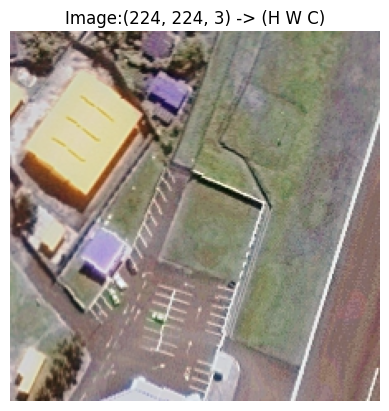

In [39]:
# Image visualization
plt.imshow(img_)
plt.title(f'Image:{img_.shape} -> (H W C)');
plt.axis('off');

In [40]:
# Convert image to from BGR to GBR
img_=cv2.cvtColor(img_,cv2.COLOR_BGR2RGB)

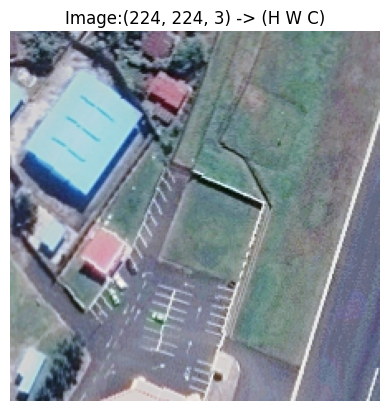

In [41]:
# Image visualization
plt.imshow(img_)
plt.title(f'Image:{img_.shape} -> (H W C)');
plt.axis('off');

## Histogram

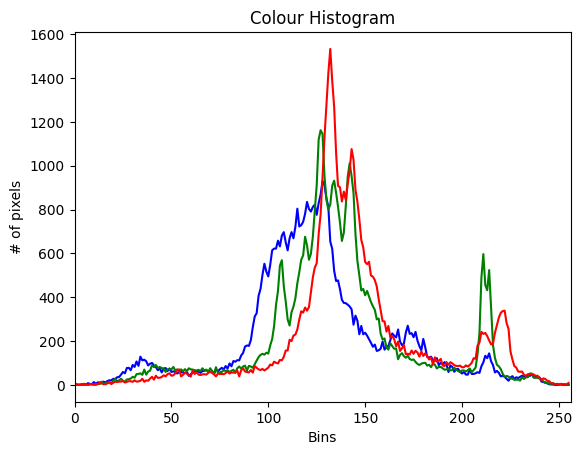

In [42]:

def hist_img(image):
  plt.figure()
  plt.title("Colour Histogram")
  plt.xlabel("Bins")
  plt.ylabel("# of pixels")
  colors=("b", "g", "r")
  for i, col in enumerate(colors):
      hist=cv2.calcHist([image], [i], None, [256], [0,256])
      plt.plot(hist, color=col)
      plt.xlim([0,256])
  plt.show()
hist_img(img_)

## Histogram equalization

In [43]:
R, G, B = cv2.split(img_)

# eaulizatio  for each channel
output1_R = cv2.equalizeHist(R)
output1_G = cv2.equalizeHist(G)
output1_B = cv2.equalizeHist(B)

equ = cv2.merge((output1_R, output1_G, output1_B))
equ.shape

(224, 224, 3)

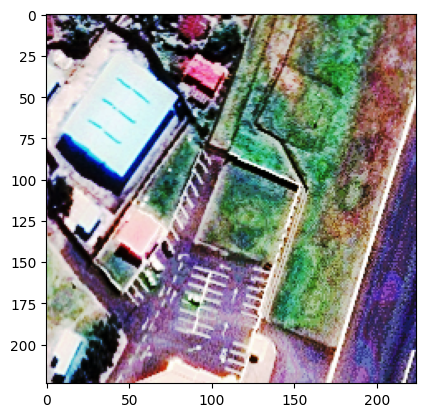

In [44]:
# Visualization
plt.imshow(equ);

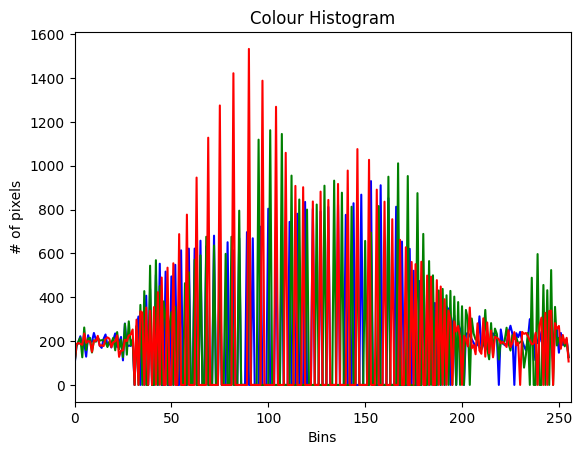

In [45]:
# Histogram after equalization
hist_img(equ)

##Image transformation

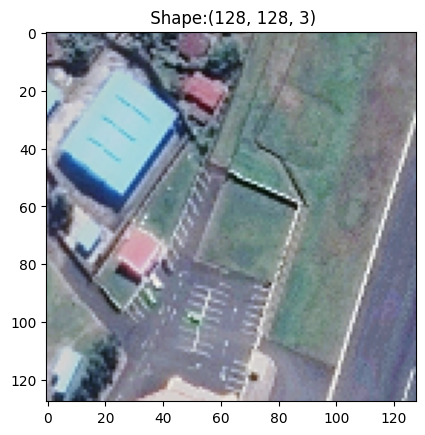

In [46]:
# Resizing
resized=cv2.resize(img_, (128,128), interpolation=cv2.INTER_CUBIC)
plt.imshow(resized)
plt.title(f' Shape:{resized.shape}');


## Flip

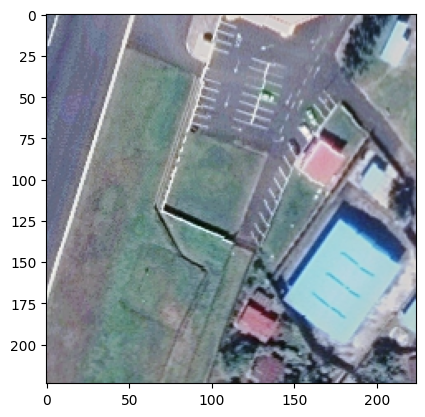

In [47]:

flip=cv2.flip(img_, -1)# 0-> vertical flip, 1-> horizontal flip, -1-> both vertical and horizontal flip
plt.imshow(flip);

## shfting an image

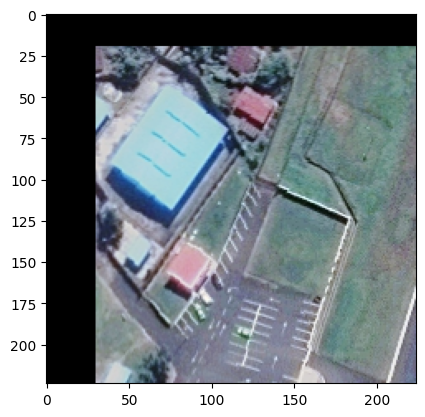

In [48]:

def shft_img(img, x, y):
    transMat=np.float32([[1,0,x],[0,1,y]])
    dimensions=(img.shape[1],img.shape[0])
    return cv2.warpAffine(img,transMat, dimensions)
# -x --> left
# -y --> Up
# x --> Right
# y --> Down
shifted_image=shft_img(img_, 30, 20)
plt.imshow(shifted_image);

## Image Pyramid

In [49]:

import numpy as np
import scipy.signal
# custom pyramid
def my_pyramid(image, levels):
    pyramid = [image]
    for _ in range(levels):
        kernel = np.array([[0.25, 0.5, 0.25],
                           [0.5, 1.0, 0.5],
                           [0.25, 0.5, 0.25]])
        blurred = scipy.signal.convolve2d(pyramid[-1], kernel, mode='same', boundary='symm')
        downsampled = blurred[::2, ::2]
        pyramid.append(downsampled)
    return pyramid

In [50]:
# Load an example image
image = cv2.imread("/content/img_dog.jpg", cv2.IMREAD_GRAYSCALE)

# Construct a custom pyramid with 4 levels
pyramid = my_pyramid(image, 4)


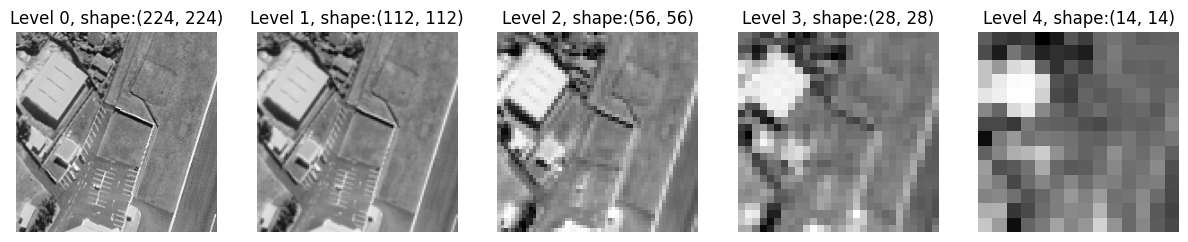

In [51]:
plt.figure(figsize=(15, 10))
for i in range(len(pyramid)):
    plt.subplot(1, len(pyramid), i + 1)
    plt.imshow(pyramid[i], cmap='gray')
    plt.title(f'Level {i}, shape:{pyramid[i].shape}')
    plt.axis('off')
plt.show()

## ⛹<font color="red">TODO</font>:

*   Resize image_lab3.jpg to 112x112
*   Visualize the resized RGB image histogram
*   Do and display a histogram equalization of the resized image
*   Construct 2 stage pyramid for the resized image

